In [2]:
import pandas as pd
import glob 
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_sim.utils.MapData import MapData
from f1tenth_sim.utils.track_utils import RaceTrack, CentreLine
from f1tenth_sim.data_tools.plotting_utils import *


if os.getcwd().split('/')[-1] == 'Notebooks':
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


In [3]:

summary_df = pd.read_csv("Logs/Summary.csv")

planner = "GlobalPlanPP"
friction_vals = np.linspace(0.55, 1, 10)
simulator_timestep_list = [2, 5, 10, 12, 14]

map_list = ["aut", "esp", "gbr", "mco"]

summary_df = summary_df[summary_df["Vehicle"] == planner]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int)
summary_df["frequency"] = 100 / summary_df["simulator_timestep"] 
# summary_df["simulator_timestep"] = int(100/timestep_series.astype(int))
summary_df["CompletionRate"] *= 100
summary_df["AvgProgress"] *= 100

n_laps = 5

# print(summary_df.sample(n=5))


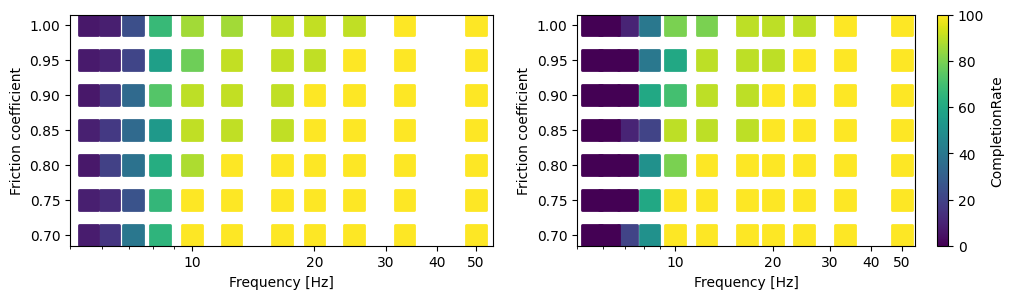

In [4]:

map_name = "aut"
# map_name = "esp"
# map_name = "mco"
# map_name = "gbr"

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

mini_df = summary_df[summary_df["MapName"] == map_name]
ax = mini_df.plot(x="frequency", y="mu", s=200, c="AvgProgress", kind="scatter", marker='s', linewidth=2, ax=axs[0], vmin=0, vmax=100, colorbar=False)
ax = mini_df.plot(x="frequency", y="mu", s=200, c="CompletionRate", kind="scatter", marker='s', linewidth=2, ax=axs[1], vmin=0, vmax=100)
# ax = mini_df.plot(x="frequency", y="mu", s=200, c="CompletionRate", kind="scatter", marker='s', linewidth=2, ax=ax)


# Set x-axis to log scale
for ax in axs:
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Friction coefficient")
    ax.set_xlim(5, 55)
    ax.set_xscale('log')

    ax.set_xticks([10, 20, 30, 40, 50])
    ax.set_xticklabels([10, 20, 30, 40, 50])


In [5]:

summary_df = pd.read_csv("Logs/Summary.csv")

planner = "FullStackPP"
friction_vals = np.linspace(0.55, 1, 10)
simulator_timestep_list = [2, 5, 10, 12, 14]

map_list = ["aut", "esp", "gbr", "mco"]

summary_df = summary_df[summary_df["Vehicle"] == planner]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int)
summary_df["frequency"] = 100 / summary_df["simulator_timestep"] 
summary_df["CompletionRate"] *= 100
summary_df["AvgProgress"] *= 100



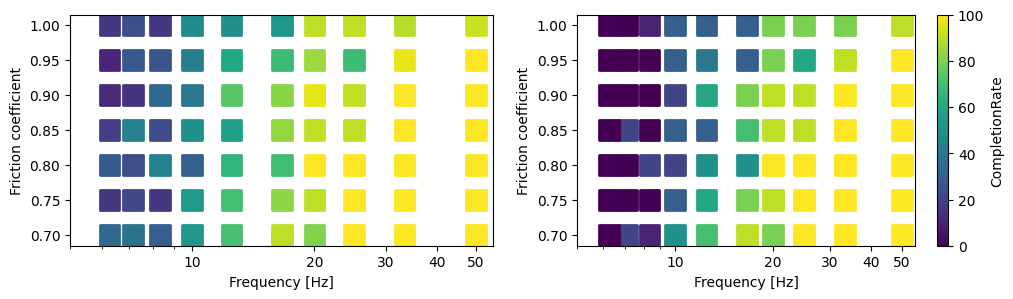

In [6]:

map_name = "aut"

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

mini_df = summary_df[summary_df["MapName"] == map_name]
ax = mini_df.plot(x="frequency", y="mu", s=200, c="AvgProgress", kind="scatter", marker='s', linewidth=2, ax=axs[0], vmin=0, vmax=100, colorbar=False)
ax = mini_df.plot(x="frequency", y="mu", s=200, c="CompletionRate", kind="scatter", marker='s', linewidth=2, ax=axs[1], vmin=0, vmax=100)
# ax = mini_df.plot(x="frequency", y="mu", s=200, c="CompletionRate", kind="scatter", marker='s', linewidth=2, ax=ax)


# Set x-axis to log scale
for ax in axs:
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Friction coefficient")
    ax.set_xlim(5, 55)
    ax.set_xscale('log')

    ax.set_xticks([10, 20, 30, 40, 50])
    ax.set_xticklabels([10, 20, 30, 40, 50])


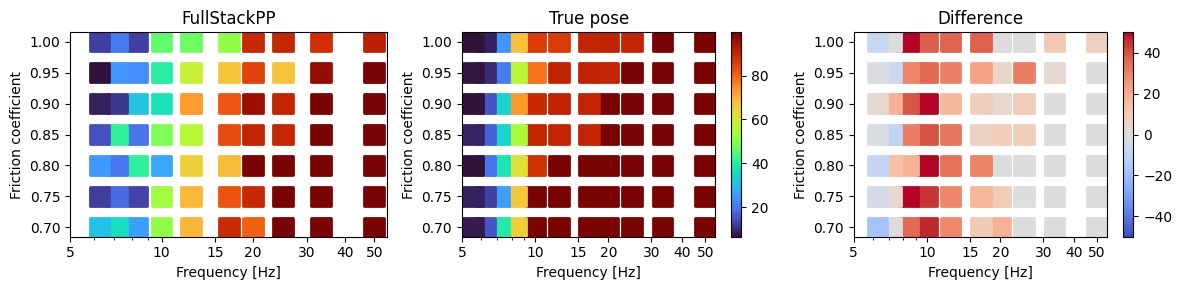

In [7]:

summary_df = pd.read_csv("Logs/Summary.csv")

planner = "FullStackPP"
friction_vals = np.linspace(0.55, 1, 10)
simulator_timestep_list = [2, 5, 10, 12, 14]

map_list = ["aut", "esp", "gbr", "mco"]

summary_df = summary_df[summary_df.Vehicle.isin(["FullStackPP", "GlobalPlanPP"])]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int)
summary_df["frequency"] = 100 / summary_df["simulator_timestep"] 
summary_df["CompletionRate"] *= 100
summary_df["AvgProgress"] *= 100


map_name = "aut"

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

full_stack = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "FullStackPP")]
axs[0].scatter(full_stack["frequency"], full_stack["mu"], s=200, c=full_stack["AvgProgress"], marker='s', linewidth=2, cmap='turbo')
axs[0].set_title("FullStackPP")

planning = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "GlobalPlanPP")]
a1 = axs[1].scatter(planning["frequency"], planning["mu"], s=200, c=planning["AvgProgress"], marker='s', linewidth=2, cmap='turbo')
plt.colorbar(a1, ax=axs[1])
axs[1].set_title("True pose")

# print(full_stack)
full_stack = full_stack.set_index("TestID")
planning = planning.set_index("TestID")
diff = planning.copy()
diff["AvgProgress"] = planning["AvgProgress"] - full_stack["AvgProgress"]
# diff = diff.loc[diff.AvgProgress > 10]

a2 = axs[2].scatter(diff["frequency"], diff["mu"], s=200, c=diff["AvgProgress"], marker='s', linewidth=2, cmap='coolwarm', vmin=-50, vmax=50)
# axs[2].colorbar()
plt.colorbar(a2, ax=axs[2])
# ax = diff.plot(x="frequency", y="mu", s=200, c="AvgProgress", kind="scatter", marker='s', linewidth=2, ax=axs[2])
axs[2].set_title("Difference")



for ax in axs:
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Friction coefficient")
    ax.set_xlim(5, 55)
    ax.set_xscale('log')

    ax.set_xticks([5, 10, 15, 20, 30, 40, 50])
    ax.set_xticklabels([5, 10, 15, 20, 30, 40, 50])

plt.tight_layout()

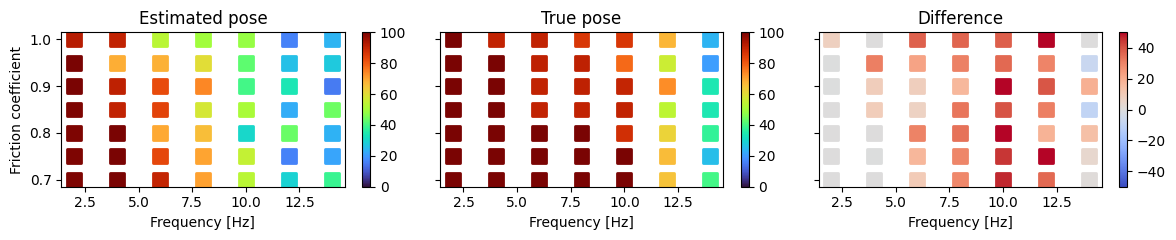

In [20]:

summary_df = pd.read_csv("Logs/Summary.csv")

planner = "FullStackPP"
friction_vals = np.linspace(0.55, 1, 10)
simulator_timestep_list = [2, 5, 10, 12, 14]

map_list = ["aut", "esp", "gbr", "mco"]

summary_df = summary_df[summary_df.Vehicle.isin(["FullStackPP", "GlobalPlanPP"])]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int)
summary_df["frequency"] = 100 / summary_df["simulator_timestep"] 
summary_df["CompletionRate"] *= 100
summary_df["AvgProgress"] *= 100

selected_timesteps = [2, 4, 6, 8, 10, 12, 14]
# selected_timesteps = [2, 3, 4, 5, 6, 8, 10, 12, 14]
summary_df = summary_df[summary_df["simulator_timestep"].isin(selected_timesteps)]

map_name = "aut"
size = 100
fig, axs = plt.subplots(1, 3, figsize=(12, 2.5), sharex=True, sharey=True)

full_stack = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "FullStackPP")]
a0 = axs[0].scatter(full_stack["simulator_timestep"], full_stack["mu"], s=size, c=full_stack["AvgProgress"], marker='s', linewidth=2, cmap='turbo', vmin=0, vmax=100)
axs[0].set_title("Estimated pose")
plt.colorbar(a0, ax=axs[0])

planning = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "GlobalPlanPP")]
a1 = axs[1].scatter(planning["simulator_timestep"], planning["mu"], s=size, c=planning["AvgProgress"], marker='s', linewidth=2, cmap='turbo', vmin=0, vmax=100)
plt.colorbar(a1, ax=axs[1])
axs[1].set_title("True pose")

full_stack = full_stack.set_index("TestID")
planning = planning.set_index("TestID")
diff = planning.copy()
diff["AvgProgress"] = planning["AvgProgress"] - full_stack["AvgProgress"]

a2 = axs[2].scatter(diff["simulator_timestep"], diff["mu"], s=size, c=diff["AvgProgress"], marker='s', linewidth=2, cmap='coolwarm', vmin=-50, vmax=50)
plt.colorbar(a2, ax=axs[2])
axs[2].set_title("Difference")


axs[0].set_ylabel("Friction coefficient")

for ax in axs:
    ax.set_xlabel("Frequency [Hz]")

    # ax.set_xlim(5, 55)
    # ax.set_xscale('log')
    # ax.set_xticks([5, 10, 15, 20, 30, 40, 50])
    # ax.set_xticklabels([5, 10, 15, 20, 30, 40, 50])

plt.tight_layout()

/tmp/ipykernel_12635/2923383123.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


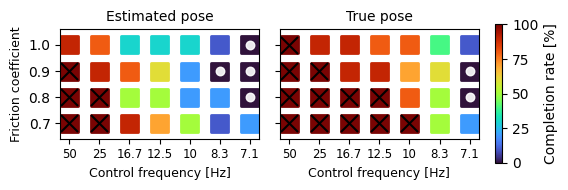

In [49]:

summary_df = pd.read_csv("Logs/Summary.csv")

planner = "FullStackPP"
friction_vals = np.linspace(0.55, 1, 10)
simulator_timestep_list = [2, 5, 10, 12, 14]

map_list = ["aut", "esp", "gbr", "mco"]

summary_df = summary_df[summary_df.Vehicle.isin(["FullStackPP", "GlobalPlanPP"])]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int)
summary_df["frequency"] = 100 / summary_df["simulator_timestep"] 
summary_df["CompletionRate"] *= 100
summary_df["AvgProgress"] *= 100

selected_timesteps = [2, 4, 6, 8, 10, 12, 14]
summary_df = summary_df[summary_df["simulator_timestep"].isin(selected_timesteps)]

friction_vals = [0.7, 0.8, 0.9, 1]
summary_df = summary_df[summary_df["mu"].isin(friction_vals)]

map_name = "aut"
size = 150
fig, axs = plt.subplots(1, 2, figsize=(5, 2.), sharex=True, sharey=True)

full_stack = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "FullStackPP")]
a0 = axs[0].scatter(full_stack["simulator_timestep"], full_stack["mu"], s=size, c=full_stack["CompletionRate"], marker='s', linewidth=2, cmap='turbo', vmin=0, vmax=100)
axs[0].set_title("Estimated pose", size=10)

complete_df = full_stack.loc[full_stack.CompletionRate >= 99]
axs[0].scatter(complete_df["simulator_timestep"], complete_df["mu"], s=size, c='k', marker='x')
complete_df = full_stack.loc[full_stack.CompletionRate <= 1]
axs[0].scatter(complete_df["simulator_timestep"], complete_df["mu"], s=size/4, edgecolors='w', marker='o', alpha=0.9, facecolor='w') 

planning = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "GlobalPlanPP")]
a1 = axs[1].scatter(planning["simulator_timestep"], planning["mu"], s=size, c=planning["CompletionRate"], marker='s', linewidth=2, cmap='turbo', vmin=0, vmax=100)

complete_df = planning.loc[planning.CompletionRate >= 99]
axs[1].scatter(complete_df["simulator_timestep"], complete_df["mu"], s=size, c='k', marker='x')
complete_df = planning.loc[planning.CompletionRate <= 1]
axs[1].scatter(complete_df["simulator_timestep"], complete_df["mu"], s=size/4, edgecolors='w', marker='o', alpha=0.9, facecolor='w')   

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0+0.05, 0.015, ax.get_position().height*0.9])
plt.colorbar(a1, cax=cax, label="Completion rate [%]")
axs[1].set_title("True pose", size=10)

axs[0].set_ylabel("Friction coefficient", size=9)
axs[0].set_ylim(0.64, 1.06)
axs[0].yaxis.set_major_locator(plt.MaxNLocator(5))


for ax in axs:
    ax.set_xlabel("Control frequency [Hz]", size=9)
    
    # ax.set_xticks([2, 6, 10, 14])
    # ax.set_xticklabels([50, 16.7, 10, 7.1])

    ax.set_xticks([2, 4, 6, 8, 10, 12, 14])
    ax.set_xticklabels([50, 25, 16.7, 12.5, 10, 8.3, 7.1], fontsize=8.5)

plt.tight_layout()

plt.savefig(save_path + "FrequencyFrictionCompletionRate.svg", bbox_inches='tight')
plt.savefig(save_path + "FrequencyFrictionCompletionRate.pdf", bbox_inches='tight')


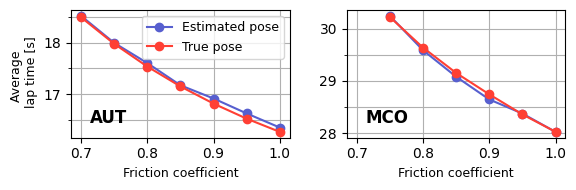

In [56]:
#TODO: add two graphs for two different maps

summary_df = pd.read_csv("Logs/Summary.csv")

planner = "FullStackPP"
friction_vals = np.linspace(0.55, 1, 10)
simulator_timestep_list = [2, 5, 10, 12, 14]

map_list = ["aut", "esp", "gbr", "mco"]

summary_df = summary_df[summary_df.Vehicle.isin(["FullStackPP", "GlobalPlanPP"])]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int)
summary_df["frequency"] = 100 / summary_df["simulator_timestep"] 
summary_df["CompletionRate"] *= 100
summary_df["AvgProgress"] *= 100

selected_timesteps = [2]
summary_df = summary_df[summary_df["simulator_timestep"].isin(selected_timesteps)]

friction_vals = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
summary_df = summary_df[summary_df["mu"].isin(friction_vals)]

map_name = "aut"
size = 150

fig, axs = plt.subplots(1, 2, figsize=(6, 2.), sharex=True)
# fig = plt.figure(figsize=(5, 2.))

full_stack = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "FullStackPP")].sort_values("mu")
planning = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "GlobalPlanPP")].sort_values("mu")

axs[0].plot(full_stack["mu"], full_stack["AvgTime"], 'o-', label="Estimated pose", markersize=6, color=periwinkle)
axs[0].plot(planning["mu"], planning["AvgTime"], 'o-', label="True pose", markersize=6, color=red_orange)

map_name = "mco"
full_stack = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "FullStackPP")].sort_values("mu")
planning = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "GlobalPlanPP")].sort_values("mu")

axs[1].plot(full_stack["mu"], full_stack["AvgTime"], 'o-', label="Estimated pose", markersize=6, color=periwinkle)
axs[1].plot(planning["mu"], planning["AvgTime"], 'o-', label="True pose", markersize=6, color=red_orange)

axs[0].yaxis.set_minor_locator(plt.MaxNLocator(5))
axs[1].yaxis.set_minor_locator(plt.MaxNLocator(5))
axs[0].set_xlabel("Friction coefficient", size=9)
axs[1].set_xlabel("Friction coefficient", size=9)
axs[0].set_ylabel("Average \n lap time [s]", size=9)
axs[0].legend(fontsize=9)
axs[1].grid(True, which='both')
axs[0].grid(True, which='both')

# axs[0].text(0.72, 16.5, "AUT", fontsize=12, fontdict={'weight': 'bold'})
# axs[1].text(0.72, 0.1, "MCO", fontsize=12, fontdict={'weight': 'bold'})
fig.text(0.18, 0.36, "AUT", fontsize=12, fontdict={'weight': 'bold'}, )
fig.text(0.64, 0.36, "MCO", fontsize=12, fontdict={'weight': 'bold'})
# axs[1].text(0.72, 28.2, "MCO", fontsize=12, fontdict={'weight': 'bold'})

plt.tight_layout()

plt.savefig(save_path + "FrictionLapTimes.svg", bbox_inches='tight')
plt.savefig(save_path + "FrictionLapTimes.pdf", bbox_inches='tight')


In [100]:

test_ids = summary_df["TestID"].unique()
# print(test_ids)
planners = ["FullStackPP", "GlobalPlanPP"]
test_id = "mu90_steps6"

map_list = ["aut"]

lap_dfs = []
for i, planner in enumerate(planners):
    for m, map_name in enumerate(map_list):
        for lap_n in range(n_laps):
            data = np.load(f"Logs/{planner}/RawData_{test_id}/SimLog_{map_name}_{lap_n}.npy")[1:, :] #remove first repeated entry
            df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
            df.steer_a = df.steer_a * 180 / np.pi
            df.yaw = df.yaw * 180 / np.pi
            df.slip = df.slip.abs() * 180 / np.pi

            el_lengths = np.linalg.norm(np.diff(data[:, :2], axis=0), axis=1)
            s_old = np.insert(np.cumsum(el_lengths), 0, 0)
            s_interp = np.linspace(0, np.sum(el_lengths), 1000)
            x_interp = np.interp(s_interp, s_old, data[:, 0])
            y_interp = np.interp(s_interp, s_old, data[:, 1])
            interp_path = np.stack([x_interp, y_interp], axis=1)
            el_lengths = np.linalg.norm(np.diff(interp_path, axis=0), axis=1)
            psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(interp_path, el_lengths, False)
            kappa_original_s = np.interp(s_old, s_interp, kappa)
            df["curvature"] = np.abs(kappa_original_s) * 180 / np.pi
            df["d_steer"] = df.steer_a.diff().abs() 
            df["lap_n"] = lap_n
            df["map_name"] = map_name
            df["test_id"] = test_id
            df["planner"] = planner

            lap_dfs.append(df)


lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)
print(lap_df.head())


          x         y  steer     speed       yaw  yaw_rate      slip  \
1  0.011412  0.000000  0.000  0.513540  0.000000  0.000000  0.000000   
2  0.056489  0.000000  0.000  1.084140  0.000000  0.000000  0.000000   
3  0.134575  0.000223  0.128  1.577648  0.127815  0.269471  1.062083   
4  0.239047  0.006116  0.320  1.956648  2.310903  1.231587  4.162318   
5  0.361730  0.027288  0.384  2.229010  8.244452  2.268007  6.153994   

     steer_a   speed_a  progress    curvature    d_steer  lap_n map_name  \
1   0.000000  4.000000       0.0     0.000000   0.000000      0      aut   
2  22.918312  3.031224       0.0    28.980279  22.918312      0      aut   
3  22.361708  3.072953       0.0   570.693728   0.556604      0      aut   
4  22.918312  3.031224       0.0  1159.012215   0.556604      0      aut   
5  17.331577  3.528223       0.0  1650.806827   5.586735      0      aut   

       test_id      planner  
1  mu90_steps6  FullStackPP  
2  mu90_steps6  FullStackPP  
3  mu90_steps6  Full

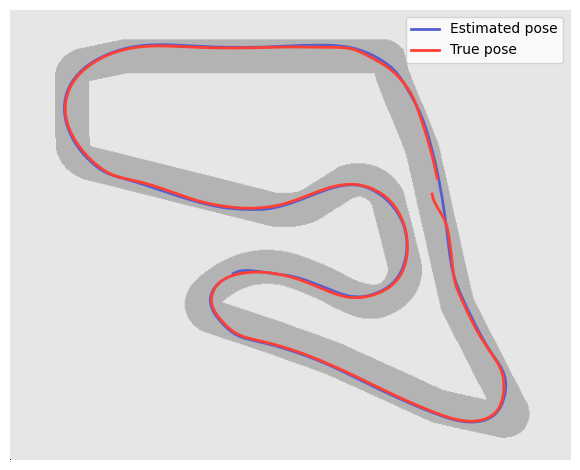

In [109]:
plot_map = "aut"
map_data = MapData(plot_map)

fig = plt.figure()
map_data.plot_map_img()
planner_colors = [periwinkle, red_orange]
neat_planner_names = ["Estimated pose", "True pose"]
for i in range(2):

    df = lap_df[lap_df["planner"] == planners[i]]
    df = df[df['lap_n'] == 3]

    xs, ys = map_data.xy2rc(df.x, df.y)
    plt.plot(xs, ys, linewidth=2, color=planner_colors[i], label=neat_planner_names[i])
    
plt.axis('off')
plt.legend()
plt.tight_layout()
# plt.xlim(660, 1480)
# plt.ylim(50, 430)

# plt.savefig(f"{save_path}path_comparison_{map_name}.pdf", bbox_inches='tight')



[ 1. 10. 12.  2.  4.  5.  6.  8.]
i: 0 - timestep: 1
i: 1 - timestep: 2
i: 2 - timestep: 4
i: 3 - timestep: 6
i: 4 - timestep: 10


/var/folders/nl/prw5ytm164qdzhwdvxnm_tdm0000gn/T/ipykernel_83013/3267502720.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


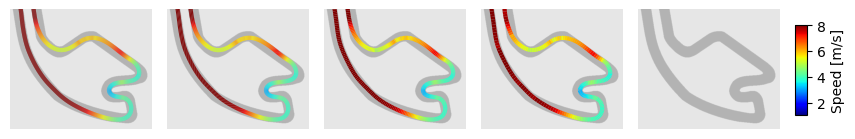

In [ ]:
plot_map = "mco"
map_data = MapData(plot_map)
map_df = lap_df[lap_df["map_name"] == plot_map]
friction = 0.9
map_df = map_df[map_df["mu"] == friction]
lap_n = 1
map_df = map_df[map_df["lap_n"] == lap_n]

print(map_df.simulator_timestep.unique())

timesteps = [1, 2, 4, 6, 10]

fig, axs = plt.subplots(1, len(timesteps), figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(len(timesteps)):
    print(f"i: {i} - timestep: {timesteps[i]}")
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = map_df[map_df['simulator_timestep'] == timesteps[i]]
    # print(df.head(n=1))

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(3)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(600, 1110)
    plt.ylim(70, 500)
    # plt.title(neat_planner_names[i])

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()


[1.]
i: 0 - Mu: 0.55
i: 1 - Mu: 0.7
i: 2 - Mu: 0.85
i: 3 - Mu: 0.95


/var/folders/nl/prw5ytm164qdzhwdvxnm_tdm0000gn/T/ipykernel_83013/3963314827.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


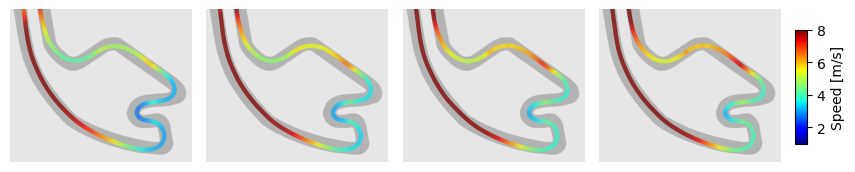

In [ ]:
plot_map = "mco"
map_data = MapData(plot_map)
map_df = lap_df[lap_df["map_name"] == plot_map]
map_df = map_df[map_df["simulator_timestep"] == 1]
lap_n = 1
map_df = map_df[map_df["lap_n"] == lap_n]

print(map_df.simulator_timestep.unique())

mus = [0.55, 0.7, 0.85, 0.95]

fig, axs = plt.subplots(1, len(mus), figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(len(mus)):
    print(f"i: {i} - Mu: {mus[i]}")
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = map_df[map_df['mu'] == mus[i]]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(3)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(600, 1110)
    plt.ylim(70, 500)
    # plt.title(neat_planner_names[i])

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()
